# Goose species classification

This notebook classifies goose species from pictures, using data augmentation and deep learning.

First, let's import relevant libraries.

In [1]:
%matplotlib inline
# show plots inline

import matplotlib.image as mpimg # import plotting library
import matplotlib.pyplot as plt # import plotting library
import numpy as np # import linear algebra library
import os # import operating system interface library
import pandas as pd # import data manipulation library
import tensorflow as tf # import deep learning library

from collections import Counter # import count function
from matplotlib import rcParams # import plotting function
from PIL import Image # import image processing tools
from sklearn.metrics import accuracy_score # import accuracy metric function
from tensorflow.keras.optimizers import RMSprop # import optimization algorithm
from tensorflow.keras.preprocessing.image import ImageDataGenerator # import image preprocessing tools

The dataset is composed of pictures of geese gathered from Wikimedia Commons.

In [2]:
train_main_dir = os.path.join('goose_train') # save path to training data
train_sub_dirs = [os.path.join(train_main_dir+"\\"+i) for i in os.listdir(train_main_dir)] # class-specific training paths

test_main_dir = os.path.join('goose_test') # save path to test data
test_sub_dirs = [os.path.join(test_main_dir+"\\"+i) for i in os.listdir(test_main_dir)] # class-specific test paths

classes = os.listdir(train_main_dir) # store class names

for i in range(len(train_sub_dirs)): # for all classes
    print(len(os.listdir(train_sub_dirs[i])), '\timages of' , classes[i]) # print count of images

114 	images of bar_headed_goose_anser_indicus
383 	images of canada_goose_branta_canadensis
296 	images of egyptian_goose_alopochen_aegyptiaca
167 	images of greylag_goose_anser_anser


Because of Github file size restrictions, I could not upload the dataset. To find more information about images used, you may look up the URLS provided in images.csv or look at the result section below.

In [3]:
file_names = [] # create empty list
file_URLs = [] # create empty list

all_sub_dirs = train_sub_dirs + test_sub_dirs # create list of all subdirectories 

for i in range(len(all_sub_dirs)): # for all subdirectories
    current_directory_files = os.listdir(all_sub_dirs[i]) # gather file names
    
    for j in range(len(current_directory_files)): # for each file name
        current_file_name = str(current_directory_files[j]) # file name
        current_file_URL = 'https://commons.wikimedia.org/w/index.php?search='+current_file_name # URL        
        file_names.append(current_file_name) # append file name to list
        file_URLs.append(current_file_URL) # append URL to list

df = pd.DataFrame() # create dataframe
df['image_name'] = file_names # with file names as column
df['image_URL'] = file_URLs # and URLs as column
df.to_csv('images.csv', index=False, encoding='utf-8-sig') # write dataframe to csv file

Next, images are processed and rescaled as arrays of figures between 0 and 1.

Because there are few images per species, the data is also augmented – that is, at the time of training, each image is slightly transformed to create additional data that the deep learning model can learn from. Here, data is augmented using rotation (rotating the image by up to 15 degrees), brigthness (varying image brightness between +50% and -50%) and zoom (using 50% to 80% of the original image).

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255, # rescale RGB values by 1/255
                                   rotation_range=15, # augment data by rotating image
                                   brightness_range=[0.5,1.5], # augment data by varying brightness
                                   zoom_range=[0.5,0.8]) #  augment data by zooming in on image

batch_size = 10 # number of images processed by CNN in one batch

train_generator = train_datagen.flow_from_directory( # process images by batch
                                                    os.path.join('goose_train'), # directory
                                                    target_size=(200, 200), # resize all images to 200x200
                                                    batch_size=batch_size, # define batch size
                                                    classes=classes, # define class names
                                                    class_mode='categorical') # classes are categorical

Found 960 images belonging to 4 classes.


Then, a Convolutional Neural Network (CNN) model is built and compiled.

In [5]:
model = tf.keras.models.Sequential([ # build model 
                                    tf.keras.layers.Conv2D(16, # number of output filters in the convolution
                                                           (3,3), # height and width of the 2D convolution window
                                                           activation='relu', # activation function
                                                           input_shape=(200, 200, 3)), # 200x200 images with 3 bytes color
                                    tf.keras.layers.MaxPooling2D(2, 2), # max pooling
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), # 2D convolution layer
                                    tf.keras.layers.MaxPooling2D(2,2), # max pooling
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), # 2D convolution layer
                                    tf.keras.layers.MaxPooling2D(2,2), # max pooling
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), # 2D convolution layer
                                    tf.keras.layers.MaxPooling2D(2,2), # max pooling
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), # 2D convolution layer
                                    tf.keras.layers.MaxPooling2D(2,2), # max pooling
                                    tf.keras.layers.Flatten(), # flatten results
                                    tf.keras.layers.Dense(128, activation='relu'), # 128-neuron dense layer
                                    tf.keras.layers.Dense(len(classes), # output neurons
                                                          activation='softmax') # activation function
                                  ])

model.compile(loss='categorical_crossentropy', # use categorical_crossentropy loss function
              optimizer=RMSprop(lr=0.001), # use RMSprop optimization function
              metrics=['acc']) # use accuracy as metric

W1115 09:50:47.904914 25456 deprecation.py:506] From C:\Users\DL\Anaconda3\envs\env_3.7\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Subsequently, the model trains on data while dealing with class imbalance. The loss function is weighted by class in order to ensure classes with less training data are suitably considered.

In [6]:
total_sample=train_generator.n # count training samples

counter = Counter(train_generator.classes) # count training samples per class                     
max_val = float(max(counter.values())) # identify max training samples  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()} # process as class weights

n_epochs = 20 # number of epochs

history = model.fit_generator(train_generator, # using train generator defined above
                              steps_per_epoch=int(total_sample/batch_size), # steps per epoch
                              epochs=n_epochs, # number of epochs
                              verbose=1, # set verbose
                              class_weight=class_weights) # weigh loss function by class

Epoch 1/20
96/96 [==============================] - 179s 2s/step - loss: 2.2522 - acc: 0.3531
Epoch 2/20
96/96 [==============================] - 182s 2s/step - loss: 2.0630 - acc: 0.4677
Epoch 3/20
96/96 [==============================] - 180s 2s/step - loss: 1.8848 - acc: 0.5135
Epoch 4/20
96/96 [==============================] - 210s 2s/step - loss: 1.7081 - acc: 0.5646
Epoch 5/20
96/96 [==============================] - 184s 2s/step - loss: 1.5665 - acc: 0.6198
Epoch 6/20
96/96 [==============================] - 175s 2s/step - loss: 1.4150 - acc: 0.6823
Epoch 7/20
96/96 [==============================] - 176s 2s/step - loss: 1.2327 - acc: 0.7031
Epoch 8/20
96/96 [==============================] - 177s 2s/step - loss: 1.1233 - acc: 0.7490
Epoch 9/20
96/96 [==============================] - 174s 2s/step - loss: 1.1880 - acc: 0.7552
Epoch 10/20
96/96 [==============================] - 175s 2s/step - loss: 1.0031 - acc: 0.7865
Epoch 11/20
96/96 [==============================] - 173s 2

Despite lack of data, we obtain a high test accuracy score, owing to data augmentation.

In [7]:
y_true = [] # create empty list
y_pred = [] # create empty list

for i in range(len(test_sub_dirs)): # for all classes
    sub_dir = test_sub_dirs[i] # subdirectory
    files = os.listdir(sub_dir) # list of files in subdirectory

    for file in files: # for each file
        file_dir = os.path.join(sub_dir, file) # file directory
        img = Image.open(str(file_dir)) # open image file
        img = img.resize((200,200)) # resize image
        img = np.expand_dims(img, axis=0) # expand shape of array
        result = model.predict(img) # predict on image
        result = classes[result.argmax()] # get class name
        
        y_true.append(classes[i]) # append true class to list
        y_pred.append(result) # append predicted class to list

print('Test set accuracy:', accuracy_score(y_true, y_pred)) # print accuracy score on test set with balanced classes

Test set accuracy: 0.9


Finally, we can visualise test results class by class.

In [8]:
def visualise_species(query): # define function
    print() # print blank line
    print(query) # print class
    
    species_test_dir = os.path.join(test_main_dir, query) # class test directory
    species_test_files = os.listdir(species_test_dir) # class test files

    rcParams['figure.figsize'] = 17, 8 # set figure width and height
    fig, ax = plt.subplots(2, 5) # set subplots
    
    species_image_index = 0 # set image index

    for row in range(2): # for each row
        for column in range(5): # for each column
            img = Image.open(os.path.join(species_test_dir,species_test_files[species_image_index])) # open image file
            img = img.resize((200,200)) # resize image
            ax[row,column].imshow(img) # show image
            ax[row,column].axis('Off') # do not display axis
            
            img = np.expand_dims(img, axis=0) # expand shape of array
            result = model.predict(img) # predict on image
            result = classes[result.argmax()] # get class name
            
            if result == query: # if prediction matches class
                title = '✓ Classified correctly' # title
            
            else: # otherwise
                title = 'X Classified incorrectly' # title
            
            ax[row,column].set_title(title) # set title
            
            species_image_index+=1 # add 1 to image index
            
    print() # print blank line


bar_headed_goose_anser_indicus



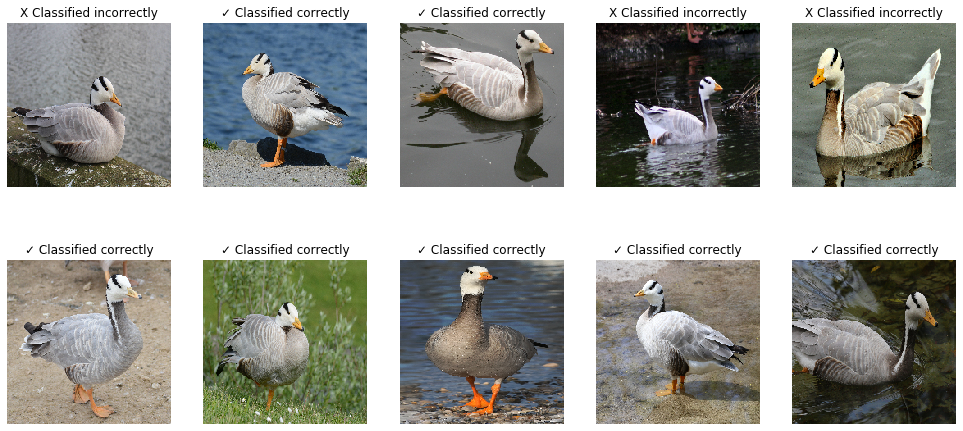

In [9]:
visualise_species('bar_headed_goose_anser_indicus') # call function


canada_goose_branta_canadensis



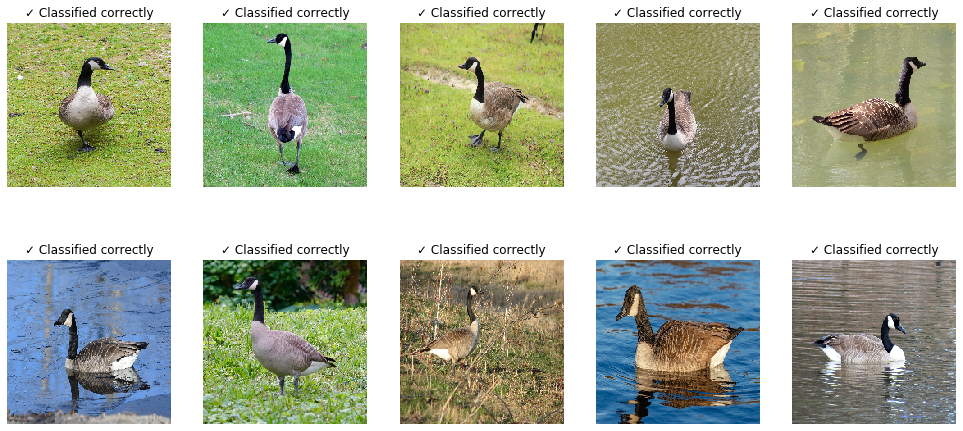

In [10]:
visualise_species('canada_goose_branta_canadensis') # call function


egyptian_goose_alopochen_aegyptiaca



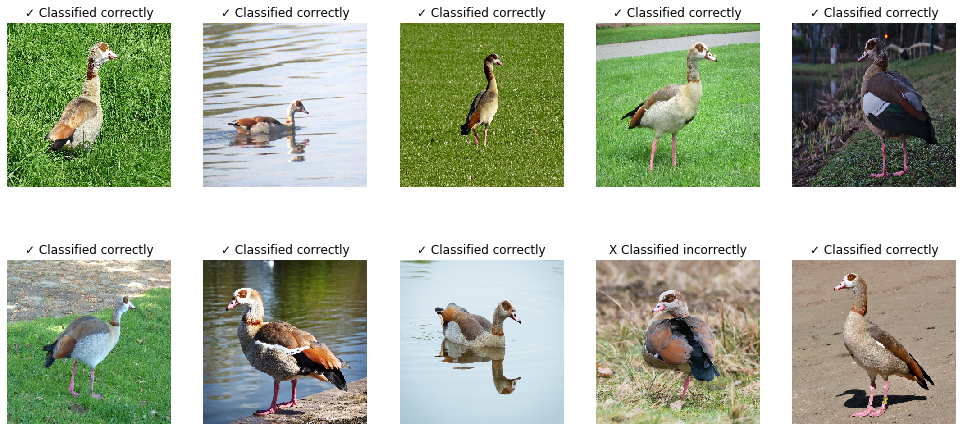

In [11]:
visualise_species('egyptian_goose_alopochen_aegyptiaca') # call function


greylag_goose_anser_anser



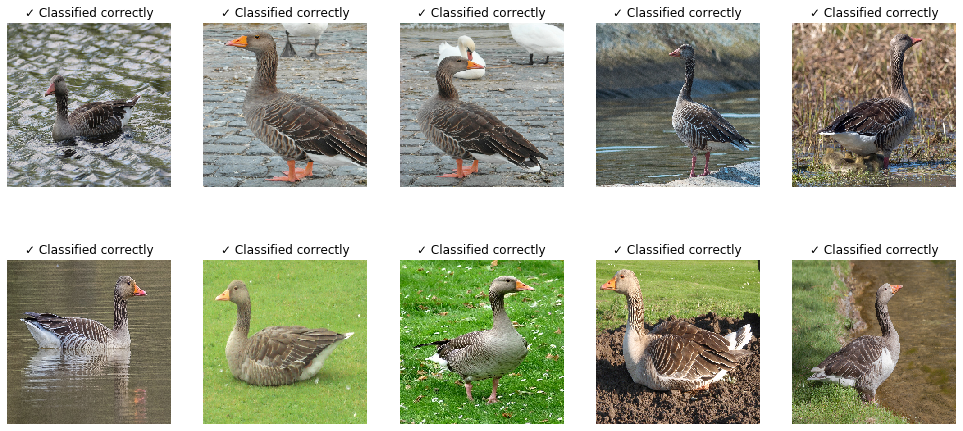

In [12]:
visualise_species('greylag_goose_anser_anser') # call function